# Exercise 4: recommender System

In [60]:
#check if notebook runs in colab
import sys
IN_COLAB = 'google.colab' in sys.modules
print('running in Colab:',IN_COLAB)
path='..'
if IN_COLAB:
  #in colab, we need to clone the data from the repo
  !git clone https://github.com/keuperj/DataScienceSS20.git
  path='DataScienceSS20'

running in Colab: False


## Code from the lecture

In [61]:
#read data to DataFrames
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(path+'/DATA/movielens100k/u.user', sep='|', names=u_cols, encoding = "ISO-8859-1")

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(path+'/DATA/movielens100k/u.data', sep='\t', names=r_cols, encoding = "ISO-8859-1")

m_cols=['movie_id', 'title', 'release date', 'video release date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv(path+'/DATA/movielens100k/u.item', sep='|', names=m_cols ,encoding = "ISO-8859-1" )

In [62]:
def getTopN(movie_id, D, N=5):
    return D[movie_id,:].argsort()[-N:]

def getIDbyName(name):
    if np.size(movies.movie_id[movies.title.str.contains(name)]) > 0:
        m = int(movies.movie_id[movies.title.str.contains(name)][:1]), str(movies.title[movies.title.str.contains(name)][:1])
        return m[0]-1
    else:
        return -1
    
def getNameByID(IDs):
    res=movies.iloc[IDs]
    return res.title

def CII(title):
    if getIDbyName(title) > 0:
        print ("recommending movies for: '" + str(getNameByID(getIDbyName(title)))+"'")
        return getNameByID(getTopN(getIDbyName(title)))[::-1]
    else:
        print ("no movie title containing " + str(title) + "found...")
        
def Score_byID(ID, D, Test):
    #print ("Hit Scores for: ", getNameByID(ID))
    res_id = getTopN(ID,D)[::-1]
    res_title = getNameByID(getTopN(ID,D))[::-1]
    res_score = Test[res_id]
    return res_id, res_title, res_score, np.mean(res_score)
    
#compute scores for all test users
def test_Score(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            res_id, res_title, res_score, av_score = Score_byID(e,D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

In [63]:
#gerate matrix (this can be done more efficiently!)
R=np.zeros((np.shape(users)[0],np.shape(movies)[0]))
for i in range(np.shape(ratings)[0]):
    R[ratings['user_id'][i]-1, ratings['movie_id'][i]-1]=ratings['rating'][i]

In [64]:
import scipy.spatial
D=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R.T, metric='cosine'))
D=np.abs(np.nan_to_num( D-1)) #dist to similarity 
np.fill_diagonal(D,0) #set self-dist to zero

## 4.1 Alternative Distance Measures
Implement a different distance measure, e.g. eucledian and compare the results.

In [65]:
#calculate euclidean distance
euclidean_distance=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R.T, metric='euclidean'))
euclidean_distance=np.abs(np.nan_to_num( euclidean_distance-np.max(euclidean_distance))) #dist to similarity 
np.fill_diagonal(euclidean_distance,0) #set self-dist to zero


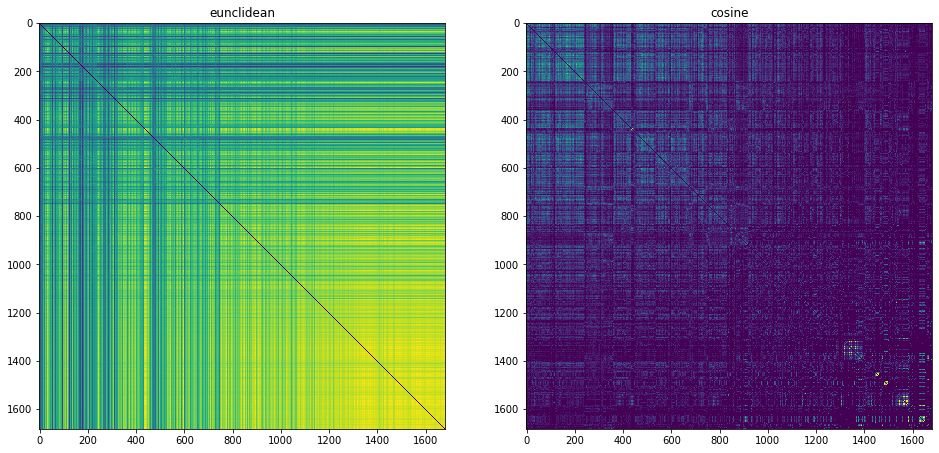

In [66]:
#plot cosine and euclidean
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 8))
ax1 = plt.subplot(121)
ax1.imshow(euclidean_distance)
ax1.set_title("eunclidean")
ax2 = plt.subplot(122)
ax2.imshow(D)
ax2.set_title("cosine")
plt.show()

mean cos =  2.2282105263157894
mean eucl =  1.5452631578947373


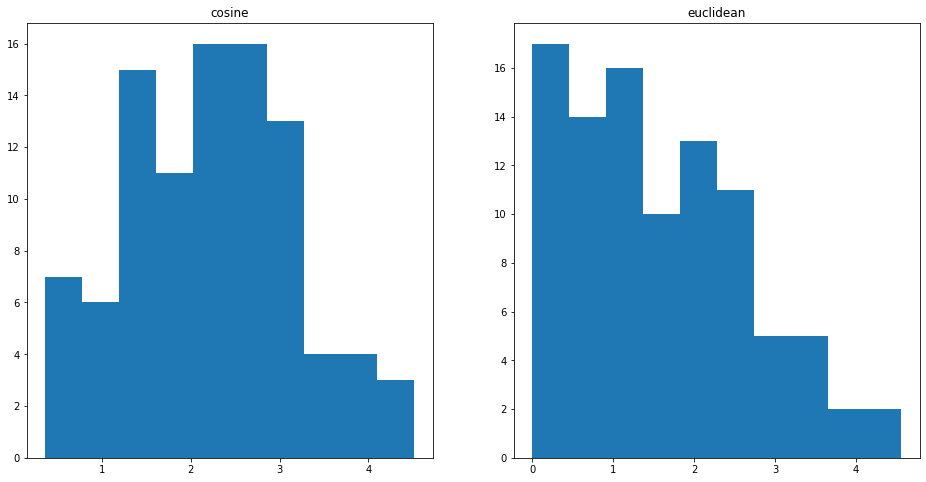

In [67]:
#compare cosine and euclidean using score

#split into train and test data (copy from lecture)
from sklearn.model_selection import train_test_split
R_train, R_test = train_test_split(R, test_size=0.1)

cos=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R_train.T, metric='cosine'))
cos=np.abs(np.nan_to_num( cos-1)) #dist to similarity 
np.fill_diagonal(cos,0) #set self-dist to zero
test_cos=test_Score(cos,R_test)
#print(test_cos)
print('mean cos = ', str(np.mean(test_cos)))

eucl=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(R_train.T, metric='euclidean'))
eucl=np.abs(np.nan_to_num( eucl-1)) #dist to similarity 
np.fill_diagonal(eucl,0) #set self-dist to zero
test_eucl=test_Score(eucl,R_test)
#print(test_eucl)
print('mean eucl = ', str(np.mean(test_eucl)))

fig=plt.figure(figsize=(16, 8))
ax1=plt.subplot(121)
ax1.set_title('cosine')
plt.hist(test_cos)
ax2= plt.subplot(122)
ax2.title.set_text('euclidean')
plt.hist(test_eucl)
plt.show()

Eulidean is worse than cosine

## 4.2 Baseline Results
Implement and compare results of
* random recommendations
* allways recommending the top 5 movies (over all users)

In [68]:
def randomRecommendation(D):
    return np.random.randint(np.shape(D)[0], size=5)
    
def topRecommendation(R):
    average_rating = np.sum(R,axis=0) / np.count_nonzero(R,axis=0)
    return np.argsort(average_rating)[-5:]
    

What is the criteria for "top movie"?
My definition:
best average rating
not an optimal solution because of the different number ratings

In [69]:
def Score_random(D, Test):
    res_id = randomRecommendation(D)[::-1]
    res_score = Test[res_id]
    return np.mean(res_score)

def Score_top(R, Test):
    res_id = topRecommendation(R)[::-1]
    res_score = Test[res_id]
    return np.mean(res_score)
    
def test_Score_random(D_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            av_score = Score_random(D_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

def test_Score_top(R_train, R_test):
    userScores=[]
    for i in range(R_test.shape[0]):
        userScore=0
        userTop = np.argsort(R_test[i])[-5:]
        for e in userTop:
            av_score = Score_top(R_train, R_test[i])
            userScore+=av_score
        userScores.append(userScore/(5))
    return userScores

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


random: 0.19705263157894737 top: 0.02947368421052632


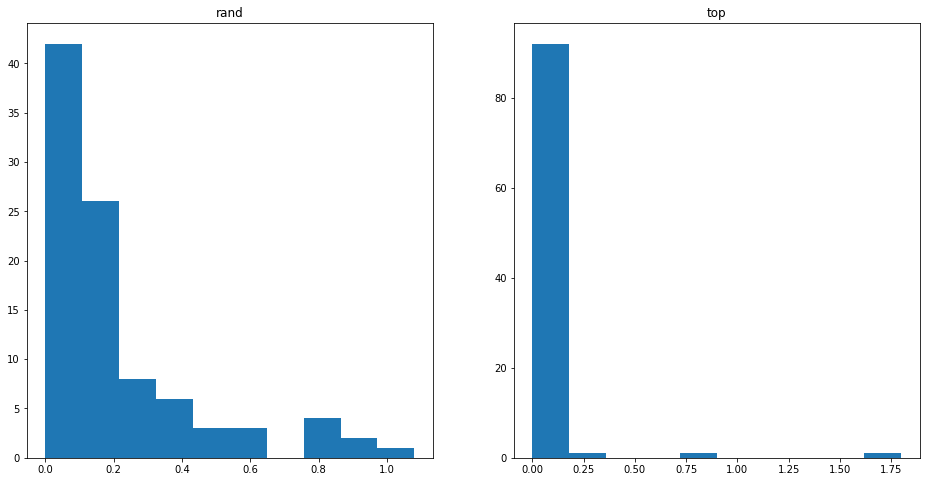

In [70]:
test_random=test_Score_random(cos,R_test)
test_top=test_Score_top(R_train,R_test)
print("random:",np.mean(test_random), "top:",np.mean(test_top))
fig=plt.figure(figsize=(16, 8))
ax1=plt.subplot(121)
ax1.set_title('rand')
plt.hist(test_random)
ax2= plt.subplot(122)
ax2.title.set_text('top')
plt.hist(test_top)
plt.show()

## 4.3 SVD
Implement the SVD approach. Hints: 
* use numpy.linalg.svd()
* apply SVD on $R$
* plot the singular values and decide where to cut off the reconstruction
* reconstruct R and evaluate $R'$
* compute the distance between two movies using $R'$


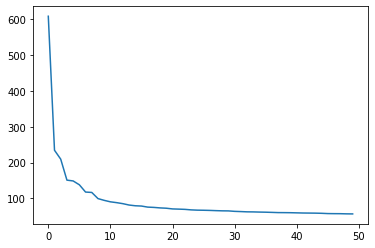

In [71]:
# apply svd
U,S,V=np.linalg.svd(R_train)
# plot S
plt.plot(S[:50]) #plot close to zero to choose h

In [72]:
h = 15
short_R = np.dot(U[:,:h] * S[:h], V[:h,:])

In [73]:
np.allclose(R_train, np.dot(U * S, V[:848,:])) 

True

In [74]:
D_with_short_R=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(short_R.T, metric='cosine'))
D_with_short_R=np.abs(np.nan_to_num( D_with_short_R-1)) #dist to similarity 
np.fill_diagonal(D_with_short_R,0) #set self-dist to zero

test_short=test_Score(D_with_short_R,R_test)

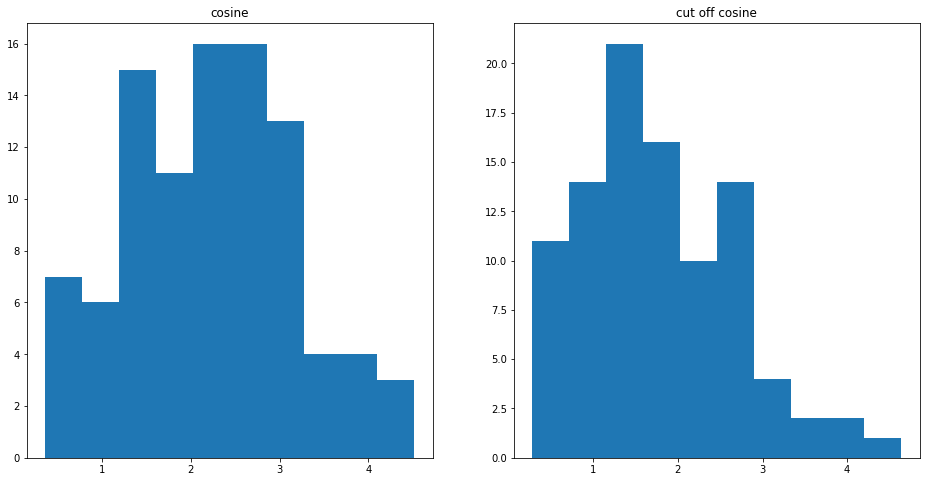

In [75]:
fig=plt.figure(figsize=(16, 8))
ax1=plt.subplot(121)
ax1.set_title('cosine')
plt.hist(test_cos)
ax2= plt.subplot(122)
ax2.title.set_text('cut off cosine')
plt.hist(test_short)
plt.show()